tensor(0.4932)
tensor(0.3231)


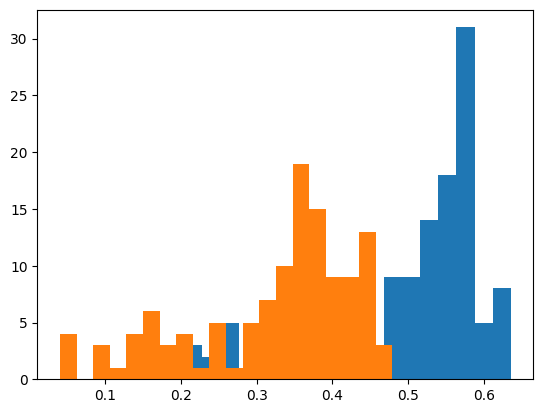

dict_keys(['labels', 'valence', 'arousal', 'scores'])
labels
torch.Size([122])
valence
torch.Size([122])
arousal
torch.Size([122])
scores
torch.Size([122, 8])


In [16]:
import torch

path = "/fsx/behavioural_computing_data/face_generation_data/MEAD/emotions/M030/video/front/happy/level_3/005.pt"

# Load emotion
emotion = torch.load(path)
import matplotlib.pyplot as plt

print(emotion["valence"].mean())
print(emotion["arousal"].mean())
# Plot valence and arousal histograms
plt.hist(emotion["valence"].numpy(), bins=20)
plt.hist(emotion["arousal"].numpy(), bins=20)
plt.show()

print(emotion.keys())
for key in emotion.keys():
    print(key)
    print(emotion[key].shape)


Results for M003:
--------------------
happy     : valence = 0.504, arousal = 0.319
angry     : valence = -0.443, arousal = 0.908
fear      : valence = 0.022, arousal = 0.860
sad       : valence = -0.362, arousal = 0.658
disgusted : valence = -0.430, arousal = 0.883
contempt  : valence = 0.271, arousal = 0.389
surprised : valence = -0.132, arousal = 0.926

Results for M030:
--------------------
happy     : valence = 0.559, arousal = 0.386
angry     : valence = -0.283, arousal = 0.667
fear      : valence = 0.181, arousal = 0.949
sad       : valence = -0.426, arousal = 0.129
disgusted : valence = -0.356, arousal = 0.704
contempt  : valence = 0.307, arousal = 0.535
surprised : valence = 0.067, arousal = 1.077

Results for W015:
--------------------
happy     : valence = 0.474, arousal = 0.330
angry     : valence = -0.433, arousal = 0.766
fear      : valence = -0.242, arousal = 0.447
sad       : valence = -0.448, arousal = -0.051
disgusted : valence = -0.484, arousal = 0.876
contempt  : v

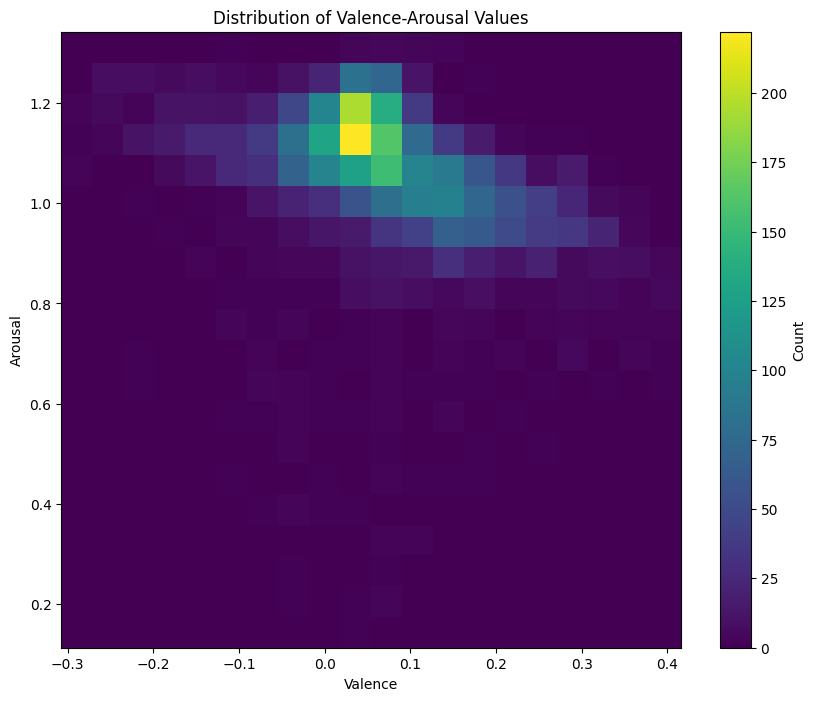

In [47]:
import os
import numpy as np

emotions = ["happy", "angry", "fear", "sad", "disgusted", "contempt", "surprised"]
subjects = ["M003", "M030", "W015", "W009"]

for subject in subjects:
    print(f"\nResults for {subject}:")
    print("-" * 20)

    for emotion in emotions:
        path = f"/fsx/behavioural_computing_data/face_generation_data/MEAD/emotions/{subject}/video/front/{emotion}/level_3/"

        if not os.path.exists(path):
            continue

        # Get all emotion files
        emotion_files = [f for f in os.listdir(path) if f.endswith(".pt")]

        if not emotion_files:
            continue

        # Store all valence and arousal values
        all_valence = []
        all_arousal = []

        # Load each emotion file and collect values
        for ef in emotion_files:
            emotion_data = torch.load(os.path.join(path, ef))
            all_valence.extend(emotion_data["valence"].numpy())
            all_arousal.extend(emotion_data["arousal"].numpy())

        # Convert to numpy arrays
        all_valence = np.array(all_valence)
        all_arousal = np.array(all_arousal)

        # Create 2D histogram to find most common value pairs
        hist, xedges, yedges = np.histogram2d(all_valence, all_arousal, bins=20)
        max_idx = np.unravel_index(hist.argmax(), hist.shape)

        # Get the center values of the most populated bin
        most_common_valence = (xedges[max_idx[0]] + xedges[max_idx[0] + 1]) / 2
        most_common_arousal = (yedges[max_idx[1]] + yedges[max_idx[1] + 1]) / 2

        print(f"{emotion:10}: valence = {most_common_valence:.3f}, arousal = {most_common_arousal:.3f}")

# Plot 2D histogram
plt.figure(figsize=(10, 8))
plt.hist2d(all_valence, all_arousal, bins=20)
plt.colorbar(label="Count")
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.title("Distribution of Valence-Arousal Values")
plt.show()

In [ ]:
ost common valence value: 0.474
Most common arousal value: 0.330

In [7]:
from einops import repeat

embedding = torch.nn.Embedding(8, 256)
print(embedding(repeat(emotion["labels"], "b -> b 14")).shape)

/data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([3479, 14, 256])


In [4]:
print(emotion["valence"].max())
print(emotion["valence"].min())
print(emotion["arousal"].max())
print(emotion["arousal"].min())

tensor(0.2467)
tensor(-0.3127)
tensor(0.4399)
tensor(-0.1810)


In [9]:
import torchvision

torchvision.io.read_video_metadata

AttributeError: module 'torchvision.io' has no attribute 'read_video_metadata'

In [8]:
import torch
import time
import torchaudio
import sys

sys.path.append("..")
from scripts.util.audio.BEATs import BEATWrapper


def load_audio(file_path, target_sr=16000):
    waveform, sr = torchaudio.load(file_path)
    print("original sr", sr)
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    return waveform.squeeze(0)


def process_audio(
    model,
    audio,
    padding_mask,
    fbank_mean: float = 15.41663,
    fbank_std: float = 6.55582,
    preprocess: bool = True,
    return_embedding: bool = True,
):
    start_time = time.time()
    if audio.dim() == 1:
        audio = audio.unsqueeze(0)
    with torch.no_grad():
        print(audio.shape)
        output = model.beats.extract_features(
            audio,
            padding_mask,
            fbank_mean,
            fbank_std,
            preprocess,
            return_embedding,
        )[0]
    end_time = time.time()
    return output, end_time - start_time


def compare_outputs(output1, output2, tolerance=1e-6):
    diff = torch.abs(output1 - output2)
    max_diff = torch.max(diff).item()
    mean_diff = torch.mean(diff).item()
    return max_diff <= tolerance, max_diff, mean_diff


# Load and initialize the BEATWrapper
model = BEATWrapper(
    fine_tuned=True,
    feed_as_frames=False,
    model_path="/data/home/antoni/code/generative-models/checkpoints/BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt",
)
model.eval()

# Load an audio file
audio_path = "/fsx/behavioural_computing_data/face_generation_data/AA_processed/part_22/audio/D058_C042_07318F_001.wav"
audio = load_audio(audio_path)
print(audio.shape)

# Ensure audio length is a multiple of 2 (required by the wrapper)
if audio.size(0) % 2 != 0:
    audio = audio[:-1]

audio = audio[:16000]
# Process with None padding mask
output_none, time_none = process_audio(model, audio, padding_mask=None)

# Process with zero tensor padding mask
zero_mask = torch.zeros((1, audio.size(0))).bool()
output_zero, time_zero = process_audio(model, audio, padding_mask=zero_mask)

# Compare results
is_equal, max_diff, mean_diff = compare_outputs(output_none, output_zero)

print(f"Outputs are {'equal' if is_equal else 'different'}")
print(f"Max difference: {max_diff}")
print(f"Mean difference: {mean_diff}")
print(f"Time with None mask: {time_none:.6f} seconds")
print(f"Time with zero mask: {time_zero:.6f} seconds")
print(f"Time difference: {time_zero - time_none:.6f} seconds")

/data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


original sr 16000
torch.Size([2011819])
torch.Size([1, 16000])
torch.Size([1, 16000])
Outputs are equal
Max difference: 0.0
Mean difference: 0.0
Time with None mask: 0.300119 seconds
Time with zero mask: 0.497740 seconds
Time difference: 0.197621 seconds


In [7]:
output_zero.shape
output_none.shape

torch.Size([1, 48, 768])

In [14]:
import torch

filename = "G188_C008_0224YN_001"
print(
    torch.load(
        f"/fsx/behavioural_computing_data/face_generation_data/1000actors_nsv/audio_emb/{filename}_wav2vec2_emb.pt"
    ).shape
)
print(
    torch.load(
        f"/fsx/behavioural_computing_data/face_generation_data/1000actors_nsv/audio_emb/{filename}_beats_emb.pt"
    ).shape
)

torch.Size([367, 2, 768])
torch.Size([368, 2, 768])


In [13]:
import torchaudio

audio, sr = torchaudio.load(
    f"/fsx/behavioural_computing_data/face_generation_data/1000actors_nsv/audio/{filename}.wav"
)
audio.shape, sr, audio.shape[-1] / sr, audio.shape[-1] / 640

(torch.Size([1, 234837]), 16000, 14.6773125, 366.9328125)